In [1]:
import numpy as np
from pywt import wavedec
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import  graphviz_layout
import networkx as nx
import pandas as pd
import seaborn as sns

plt.rcParams['figure.figsize'] = [10, 10]     


def genData(param, show = False):
	a=[]
	if param[0]=="normal":
		mu, sigma, s = param[1],   param[2], param[3]
		a= np.random.normal(mu, sigma, size=s)
	elif param[0]=='uniform':
		mi, ma,s=param[1],   param[2], param[3]
		a= np.random.uniform(mi, ma, s)
	elif param[0]=="poisson":
		rate,s=param[1],   param[2]
		a = np.random.poisson(rate, s)
	if(show):
		count, bins, ignored = plt.hist(s, 14, density=True)
	return a

In [2]:
def mergeList(input_data, verbose= False):
    if verbose:
        print("merge data")
    merged_list = []
    for l in input_data:
        merged_list += list(l)
    return merged_list

In [3]:
signals= [[0,0,0,0], #zero
          [0,0,1,1], #one
          [1,1,0,0], #and
          [0,1,1,0], #or
          [0,0,0,1], #zor
          [1,0,0,1], #not
          [1,1,1,1], #equal
          [1,1,1,0] # question
         
         ]
correspondace = ["0", "1", "and", "or", "xor", "not", "equal", "question"]


In [4]:
def exec_ops(first,op,second=0,verbose = False):    
    if op =="and":
        if(verbose):
            print( first, "and", second , "=", first and second )
        return first and second
    elif op =="or":
        if(verbose):
            print( first, "or", second , "=", first or second)
        return first or second
    elif op=="xor":
        if(verbose):
            print( first, "xor", second , "=", first ^ second)
        return  first ^ second
    elif op == "not":
        if(verbose):
            print( "not",first, "=", (first+1)%2)
        return (first+1)%2

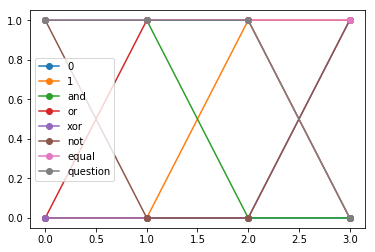

In [5]:
plt.plot(np.array(signals).T,'o-')
plt.legend(["0", "1", "and", "or", "xor", "not", "equal", "question"])
plt.show()


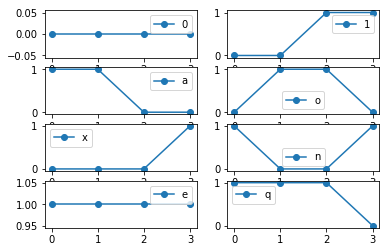

In [6]:
for i in range(len(signals)):
    ax=plt.subplot(4,2,i+1) 
    ax.plot(signals[i],'o-')
    ax.legend(correspondace[i])
plt.show()

In [7]:
def generateOperations(op_count, Test = False, verbose= False):
    #op_count=2
    b= [ int(j) for j in genData(["uniform",0,100,op_count*5])]
    #print(b)
    for i in range(op_count):
        b[i*5]=b[i*5]%2
        b[i*5+1]=b[i*5+1]%4+2
        b[i*5+2]=b[i*5+2]%2
        b[i*5+3]=6
        b[i*5+4]= exec_ops ( b[i*5], correspondace[b[i*5+1]], b[i*5+2], verbose)  
        #print(b[i*5:(i+1)*5])
    #print(b)
    return b

In [8]:
def decodeOperationsDeeper(input_data, signals):
    inputs = [] 
    for i in range(len(input_data)):
        inputs.append(signals[input_data[i]])
    return inputs

In [9]:
def initTree():
    GG=nx.DiGraph()    
    GG.add_node(0, k=999,cc=1, id = -1,food =0)    
    return GG,1

In [10]:
def train_tree(input_data, GG, counter , WL, overlap):
    plt.rcParams.update({'font.size': 22})
    data1= input_data  
    print(data1)
    poz = 0
    #print(len(data1)/WL)    
    step = WL-overlap

    for i in range(0,len(data1)-step+1, step):
        #if(data1[i:i+step]==[0,0,1,0] or  data1[i:i+step]==[1,0,0,0] ):
        #    //print(str(i)+ " food")
        poz=0
        for j in range(WL):
            # data
            d=data1[i + j]
            #print(d, end=' ')
            #print (d)
            # neighbours 
            nei= list(GG.neighbors(poz))       
            if len(nei)==0:
                #print (counter, poz, data1[i: i+step])
                GG.add_node(counter,k=d, cc=1, id = -1,food =0)    
                GG.add_edge(poz,counter)
                poz=counter
                counter +=1
            else:
                k=-1
                for n in nei:
                    if(GG.node[n]['k']==d):
                        k=n
                        break
                if(k>=0):
                    poz=k
                    GG.node[k]['cc'] = GG.node[k]['cc'] + 1
                else:
                    GG.add_node(counter,k=d,cc=1, id = -1,food =0)    
                    GG.add_edge(poz,counter)
                    poz=counter
                    counter += 1
    finalNodes = [] 
    for i in range(1, counter):
        yol =  nx.shortest_path(GG,0,i)
        if(len(yol) >WL):
            GG.node[yol[-1]]['id']=len(finalNodes)
            finalNodes.append(yol[-1])
    return GG, counter

In [11]:
def plotGraph(GG, WL, counter):
    plt.rcParams['figure.figsize'] = [15, 10]        
    labels=dict((n,d['k']) for n,d in GG.nodes(data=True))   
    #pos=nx.graphviz_layout(GG, prog='dot')
    pos =graphviz_layout(GG, prog='dot')
    #nx.spring_layout(GG)

    plt.title("node values")
    nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True, labels=labels )
    plt.show()

    plt.title("node ids")
    nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True )
    plt.show()

    plt.title("node frequency")
    labels=dict((n,d['cc']) for n,d in GG.nodes(data=True))   
    nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True, labels=labels )
    plt.show()

    

    plt.title("final nodes ids")
    labels=dict((n,d['id']) for n,d in GG.nodes(data=True))   
    nx.draw_networkx(GG,  pos=pos, arrows=True, with_labels=True, labels=labels )
    plt.show()  

In [17]:
def buildAbstractTree(GG, symbols, ops,counter, WL , overlap):
    #print(b)
    decodedOps=decodeOperationsDeeper( ops, symbols )
    
    GG,counter = train_tree( (mergeList(decodedOps)), GG, counter , WL, overlap)
    plotGraph(GG,WL,counter)
    return GG, counter

In [13]:
def getBranchId(branch,GG, counter , WL, overlap):    
    ids = []
    plt.rcParams.update({'font.size': 22})
    data1= branch  
    
    poz = 0
    #print(len(data1)/WL)    
    step = WL-overlap
    
    for i in range(0,len(data1)-step+1, step):
        k=0
        poz=0
        #print("branch = " , data1[i:i+WL])
        
        for j in range(WL):
            # data
            d=data1[i + j]
            #print("d=",d)
            # neighbours 
            nei= list(GG.neighbors(poz))       
            if len(nei)==0:
                k=-1
                break
            else:
                k=-1
                for n in nei:
                    if(GG.node[n]['k']==d):
                        k=n
                        break
                if(k>=0):
                    poz=k                    
                    #GG.node[k]['cc'] = GG.node[k]['cc'] + 1
                else:
                    k=-1
                    break            
            #print("k=",k,GG.node[k]['k'])
        #ids.append(k)
        
        #ids.append(GG.node[k]['id'])
        if(k>0):
            ids.append(GG.node[k]['id'])
        else:
            ids.append(-1)
    return ids

# Test Function

In [21]:
# Build a tree 
def initializeAbstract():
    train_ops_count = 100
    WL = 4 # window length
    overlap = 0# int(WL/5)
    GG,counter = initTree()

    ops=generateOperations(train_ops_count, Test = False, verbose= True)            
    print(ops)
    GG,counter = buildAbstractTree(GG, signals, ops, counter, WL, overlap)
    
    
    return GG, counter

0 xor 1 = 1
1 or 1 = 1
1 and 1 = 1
0 xor 1 = 1
0 or 1 = 1
not 1 = 0
0 and 1 = 0
1 or 0 = 1
0 or 1 = 1
1 or 0 = 1
1 xor 0 = 1
0 or 0 = 0
1 xor 0 = 1
1 or 0 = 1
not 0 = 1
1 and 1 = 1
1 xor 1 = 0
0 or 1 = 1
1 xor 0 = 1
not 1 = 0
1 and 1 = 1
not 1 = 0
0 xor 1 = 1
not 1 = 0
1 or 0 = 1
not 1 = 0
0 or 1 = 1
1 xor 1 = 0
0 and 1 = 0
1 xor 1 = 0
1 or 1 = 1
not 1 = 0
0 or 1 = 1
0 or 0 = 0
0 and 1 = 0
1 or 0 = 1
0 or 0 = 0
0 or 0 = 0
not 1 = 0
0 or 0 = 0
0 xor 0 = 0
0 and 0 = 0
0 or 1 = 1
1 or 1 = 1
not 1 = 0
1 or 0 = 1
not 0 = 1
0 and 0 = 0
0 xor 0 = 0
0 or 0 = 0
not 0 = 1
0 xor 1 = 1
not 1 = 0
not 0 = 1
1 xor 1 = 0
0 xor 0 = 0
0 and 1 = 0
0 xor 0 = 0
not 0 = 1
1 xor 0 = 1
0 and 0 = 0
not 0 = 1
0 or 1 = 1
not 0 = 1
not 1 = 0
0 and 0 = 0
0 and 0 = 0
1 and 1 = 1
0 and 1 = 0
1 or 0 = 1
1 and 0 = 0
1 or 0 = 1
1 xor 0 = 1
not 0 = 1
1 xor 1 = 0
1 and 1 = 1
0 or 1 = 1
not 1 = 0
0 xor 0 = 0
not 1 = 0
1 or 0 = 1
0 and 1 = 0
0 or 1 = 1
0 and 0 = 0
not 0 = 1
1 or 1 = 1
1 or 0 = 1
1 xor 0 = 1
1 xor 1 = 0
0 x

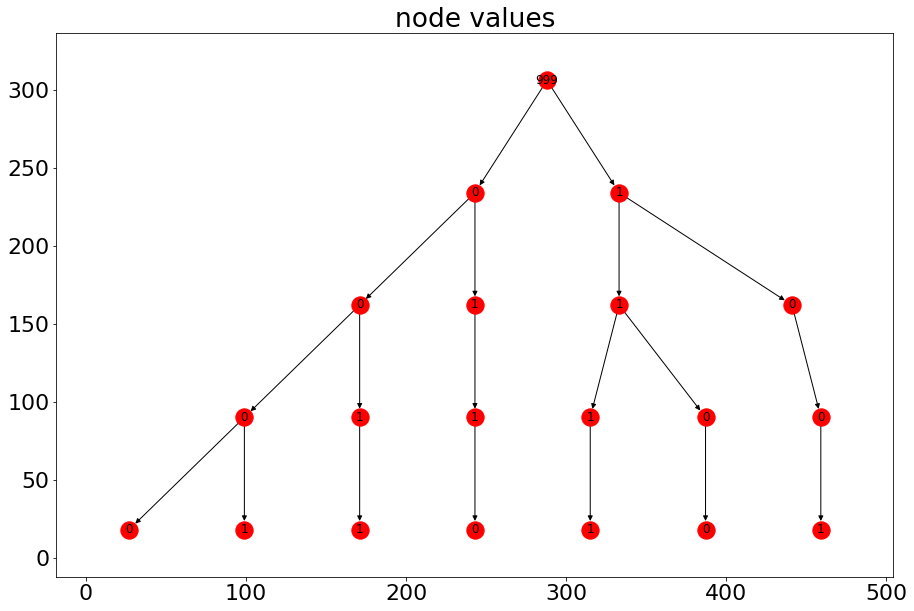

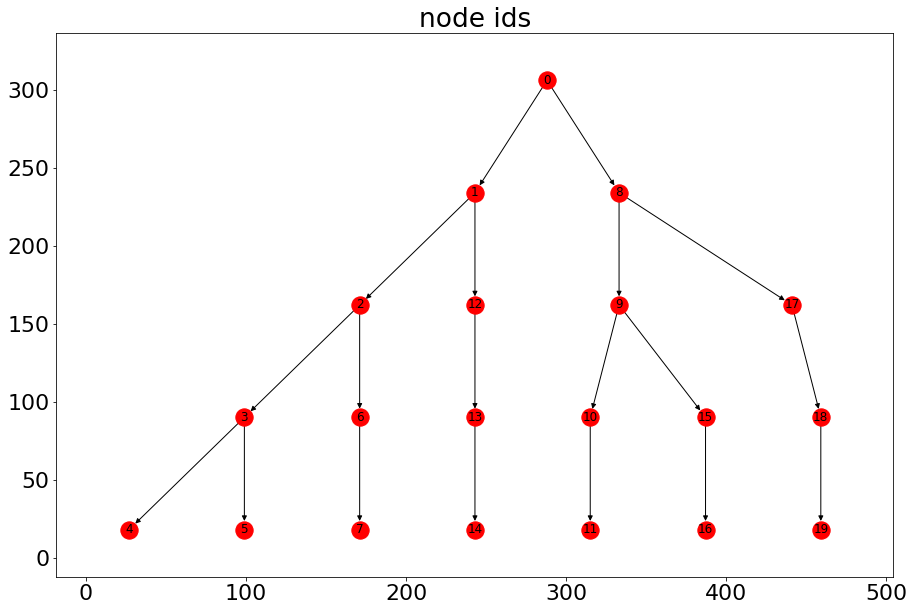

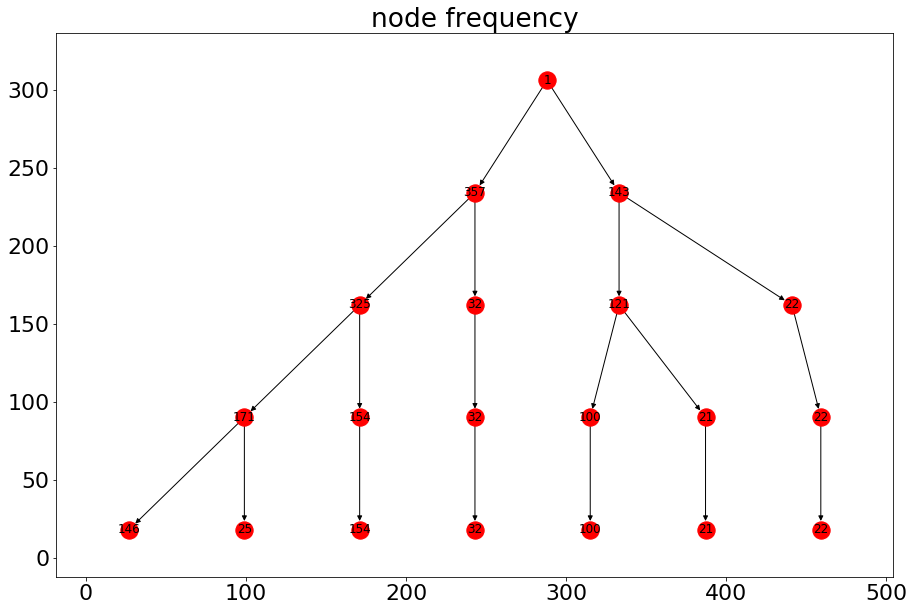

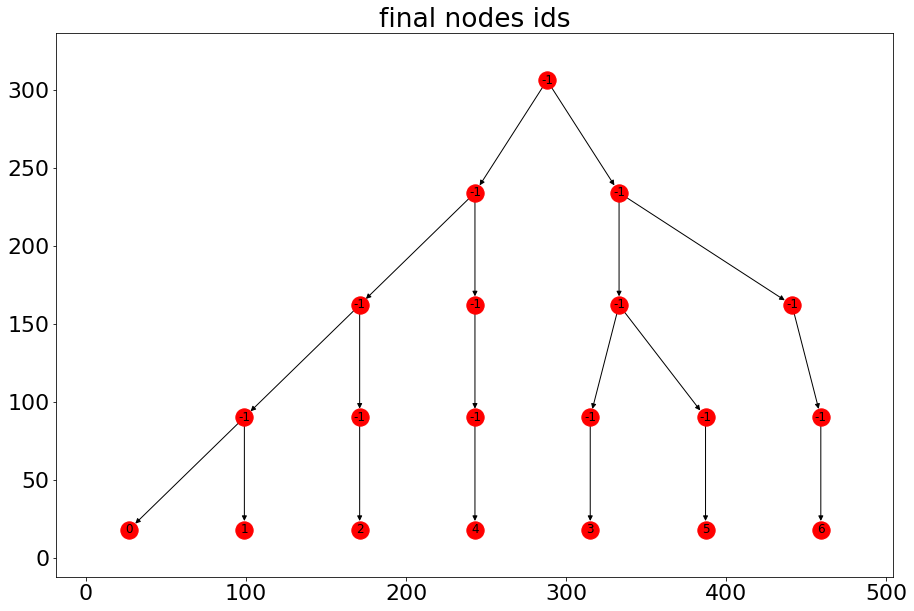

In [23]:
GG, counter =  initializeAbstract()

In [26]:

ops=generateOperations(2, Test = False, verbose= True)

print(ops)
ops_decoded = decodeOperationsDeeper( ops,signals)
print (ops_decoded)
WL=4
overlap = 0
abstract_output = getBranchId( mergeList(ops_decoded),GG, counter , WL, overlap)


1 or 0 = 1
1 or 0 = 1
[1, 3, 0, 6, 1, 1, 3, 0, 6, 1]
[[0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1], [0, 0, 1, 1], [0, 1, 1, 0], [0, 0, 0, 0], [1, 1, 1, 1], [0, 0, 1, 1]]


# Branch equvalent id's

In [27]:


for i in range(8):
    print(correspondace[i] , getBranchId(signals[i],GG, counter , WL, overlap))

0 [0]
1 [2]
and [5]
or [4]
xor [1]
not [6]
equal [3]
question [-1]


20